# Summary

### Feature engineering
- time_delta (float, in days) = purchase_time - signup_time, one of methods to convert the variables to stationary ones for analysis and learning
- past_fraud_device (boolean): the device once made any fraud transaction earlier whose makes up 50% fraud transactions
- country: replace the bottom countries based on cumulative number of observations to reduce dimension number of independent categorical variables after one-hot coding, eventually significantly save computation costs in over-, under-sampling and model selection.

### Exploratory data analysis
- The first purchases are often made shortly after their signups.
- About 50% of fraudulent transactions are commited by devices whose first counterfeit transactions are recorded and there are transactions of these types successfully committed by same devices up to 19 times.
- 22 out of 218 countries make of 90% observations.

### Precision-recall trade-off
- A decrease in precision means more false positives or false alarm. This harms sales and market shares by incorrectly classifying transactions of benign customers as fraudulent and  waste operational costs by incorrectly cancelling legit orders.
- A decrease in recall is related to false negatives or miss fraud transacitons. This causes financial loss to vendors and company.

In the precision-recall curve (PRC) below, if we favor more recall, we have to sacrifice precision along the PRC rightward by increasing the probability threshold to classify an observation as positive/fraud.

### Model training
Decision tree classifier with max_depth = 60 and min_samples_leaf = 20% (at least 20% samples at a leaf to split). The actual depth is only 3.

70% and 30% observations are randomly split into training and test sets. The trainset is then processed with RandomUnderSampling for training.

| Metrics | In-sample | Out-of-sample |
| --- | --- | --- |
| Precision | 100% | 100% |
| Recall | 53.49% | 54.21% |
| F1 | 69.70% | 70.31% |
| AUROC | 77.40% | 77.58% |

### User intepretation
The first purchases which are made shortly after their signups are often related to fraud.

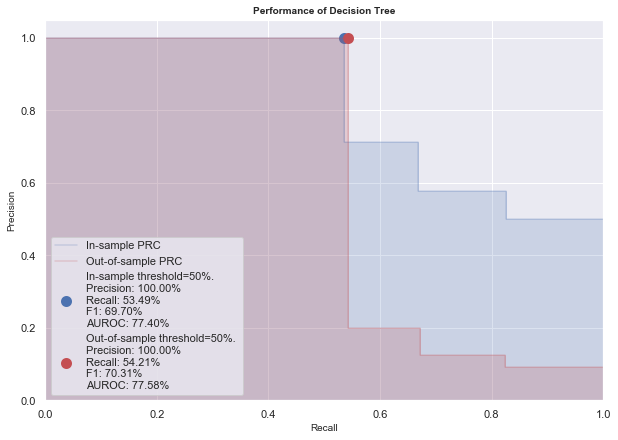

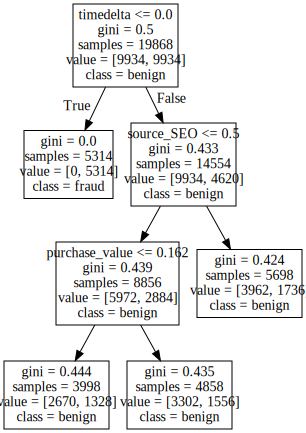

In [82]:
X_final = X_rus
y_final = y_rus

clf = DecisionTreeClassifier(max_depth=60, min_samples_leaf=0.2, random_state=RANDOM_STATE)
clf.fit(X_final, y_final)
from graphviz import Source
from sklearn import tree
plotPerformance(clf, 'Decision Tree', X_final, y_final, Xtest, ytest, figsize=(10, 7), fontsize=None)
Source(tree.export_graphviz(clf, out_file=None, feature_names=Xtrain.columns, class_names=['benign', 'fraud']))

# Code snippets and numerical analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import time

from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

In [2]:
RANDOM_STATE=42

# Data preparation

Idenfity country origins of IP addresses and compute time period between customers' signup time and their first purchases (time delta)

In [3]:
data = pd.read_csv('Fraud_Data.csv', index_col='user_id', parse_dates=['signup_time', 'purchase_time'])

ip_country = pd.read_csv('customer_countries.csv', index_col='user_id')
ip_country.name = 'ip_country'
ip_country.head()

data2 = data.merge(ip_country, left_index=True, right_index=True)
data2['timedelta'] = (data2.purchase_time - data2.signup_time) / np.timedelta64(1, 'D')

fraud = data2['class'] == 1
benign = data2['class'] == 0

data2 = data2[['signup_time',
 'purchase_time',
 'purchase_value',
 'device_id',
 'source',
 'browser',
 'sex',
 'age',
 'class',
 'country',
 'timedelta']]

data2['signup_weekday'] = data2['signup_time'].dt.weekday_name
data2['signup_hour'] = data2['signup_time'].dt.strftime('%H').add('h')

data2['purchase_weekday'] = data2['purchase_time'].dt.weekday_name
data2['purchase_hour'] = data2['purchase_time'].dt.strftime('%H').add('h')

fraud_device_cnt = data2[data2['class'] == 1].sort_values(by='purchase_time').groupby(['device_id']).cumcount()
device_fraud_idx = fraud_device_cnt[fraud_device_cnt > 0].index
data2['past_fraud_device'] = 0
data2.loc[device_fraud_idx, 'past_fraud_device'] = 1

data2['country'].fillna('NAN', inplace=True)

data2.head()

signup_time       purchase_time  purchase_value  \
user_id                                                           
22058   2015-02-24 22:55:49 2015-04-18 02:47:11              34   
333320  2015-06-07 20:39:50 2015-06-08 01:38:54              16   
1359    2015-01-01 18:52:44 2015-01-01 18:52:45              15   
150084  2015-04-28 21:13:25 2015-05-04 13:54:50              44   
221365  2015-07-21 07:09:52 2015-09-09 18:40:53              39   

             device_id source browser sex  age  class        country  \
user_id                                                                
22058    QVPSPJUOCKZAR    SEO  Chrome   M   39      0          Japan   
333320   EOGFQPIZPYXFZ    Ads  Chrome   F   53      0  United States   
1359     YSSKYOSJHPPLJ    SEO   Opera   M   53      1  United States   
150084   ATGTXKYKUDUQN    SEO  Safari   M   41      0            NAN   
221365   NAUITBZFJKHWW    Ads  Safari   M   45      0  United States   

         timedelta signup_weekday signup_hour purchase_weekday purchase_hour  \
user_id                                                                        
22058    52.160671        Tuesday         22h         Saturday           02h   
333320    0.207685         Sunday         20h           Monday           01h   
1359      0.000012       Thursday         18h         Thursday           18h   
150084    5.695428        Tuesday         21h           Monday           13h   
221365   50.479873        Tuesday         07h        Wednesday           18h   

         past_fraud_device  
user_id                     
22058                    0  
333320                   0  
1359                     1  
150084                   0  
221365                   0

# Exploratory data analysis

Before any quantitative analysis, fraudulent transactions are expected to have following characteristics. These expectations are testified with the dataset later.
- Users make their first transactions shortly after their signups: (purchase_time - signup_time) << c
- Transactions with frauds have high value: purchase_value >> c
- Devices used for past fraudulent transactions are prone to commit this crime again in the future: count(device_id with class 1) > 1
- Fraudulent transactions are made through direct channel: source = Direct

In addition, because description of users prone to committing frauds are required, classification algorithms resulting specific feature importance are chosen.

#### Weekday and hour compositions of signup and purchase times

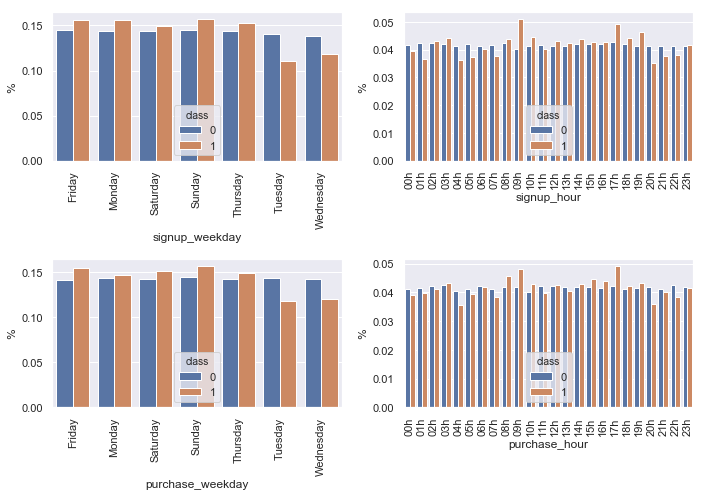

In [4]:
def plot_barplot_time(data, col_name, class_name):
    sub_data = pd.crosstab(data[class_name], data[col_name])
    sub_data = sub_data.divide(sub_data.sum(axis=1), axis=0)
    sub_data = sub_data.unstack().reset_index()
    sub_data.columns = [col_name, class_name, '%']
    sns.barplot(data=sub_data, x=col_name, y='%', hue=class_name)
    plt.xticks(rotation=90)
    
plt.subplots(2, 2, figsize=(10, 7))

for i, col_name in enumerate(['signup_weekday', 'signup_hour', 'purchase_weekday', 'purchase_hour']):
    plt.subplot(2, 2, i+1)
    plot_barplot_time(data2, col_name, 'class')
    
    
plt.tight_layout()

#### Time period between signup and first purchase

As expected, for fraud transactions, the first purchases are often made shortly after their signups.

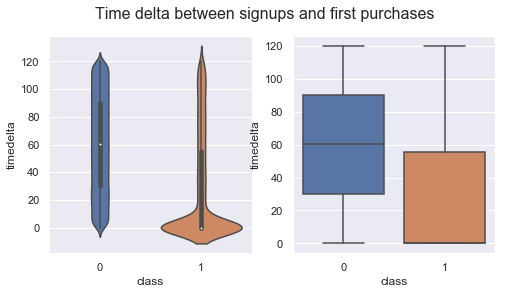

In [5]:
plt.subplots(1, 2, figsize=(8, 4))
plt.suptitle('Time delta between signups and first purchases', fontsize=16)
plt.subplot(1, 2, 1)
sns.violinplot(x='class', y='timedelta', data=data2[['class', 'timedelta']])
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='timedelta', data=data2[['class', 'timedelta']])
plt.show()

#### Repeated devices

About 50% of fraudulent transactions are commited by devices whose first counterfeit transactions are recorded and there are transactions of these types successfully committed by same devices up to 19 times.

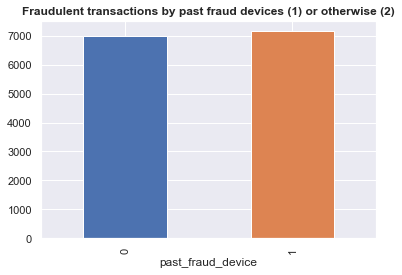

In [6]:
plt.title('Fraudulent transactions by past fraud devices (1) or otherwise (2)', fontsize=12, fontweight='bold')
data2.groupby(['past_fraud_device', 'class']).size().unstack()[1].plot(kind='bar')
plt.show()

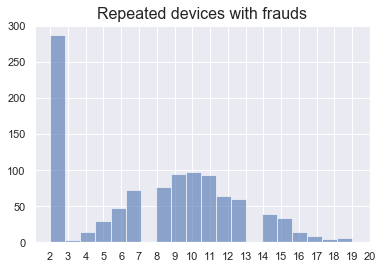

count    1044.000000
mean        7.862069
std         4.476436
min         2.000000
25%         2.000000
50%         8.000000
75%        11.000000
max        19.000000
Name: 1, dtype: float64


In [7]:
device_cnt = data2['class'].groupby([data2['device_id']]).value_counts().unstack()
device_cnt_fraud = device_cnt[1][device_cnt[1] > 1]

plt.title('Repeated devices with frauds', fontsize=16)
plt.hist(device_cnt_fraud, bins=20, alpha=0.6)
plt.xticks(np.arange(2, 21))
plt.show()

print device_cnt_fraud.describe()

#### Country

Considering countries having their numbers of transactions more frequent than 231 times (i.e. 75% percentile of all countries), more than half of these countries have fraudulent percentages more than 10%. In particular, Iceland and New Zealand bears this metrics higher than 20%.

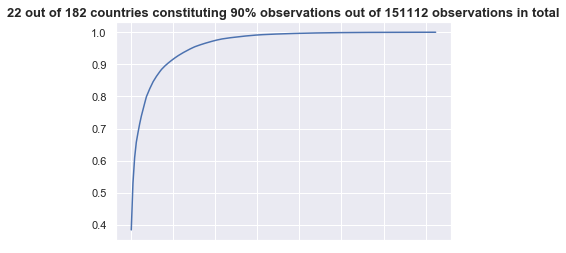

In [8]:
country_cumpct = data2['country'].value_counts(normalize=True, ascending=False, sort=True).cumsum()
title = str(country_cumpct[country_cumpct < 0.9].shape[0])\
        + ' out of ' \
        + str(country_cumpct.shape[0]) \
        + ' countries constituting 90% observations out of '\
        + str(data2.shape[0]) + ' observations in total'

plt.title(title, fontsize=13, fontweight='bold')
country_cumpct.plot()
plt.show()

In [9]:
country_cnt = data2['class'].groupby(data2['country']).value_counts().unstack()
country_fraud_pct = country_cnt[1] / country_cnt.sum(axis=1)
print country_cnt.sum(axis=1).describe()

count      182.000000
mean       830.285714
std       4718.564368
min          1.000000
25%          5.250000
50%         25.000000
75%        236.250000
max      58049.000000
dtype: float64


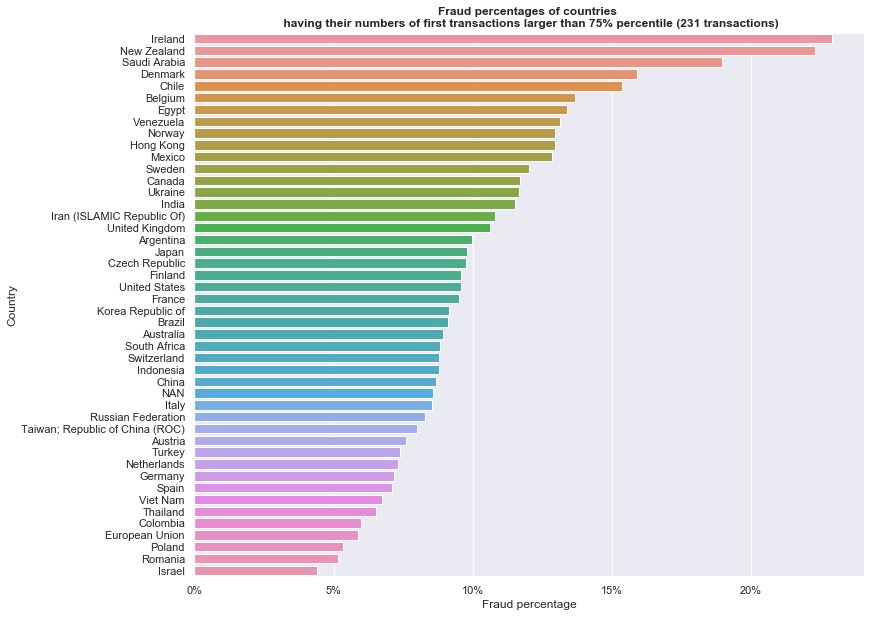

In [10]:
import matplotlib.ticker as mtick

filtered_country_fraud_pct = pd.DataFrame(country_fraud_pct[country_cnt.sum(axis=1) >= country_cnt.sum(axis=1).quantile(q=0.75)], columns=['fraud_pct'])
filtered_country_fraud_pct.reset_index(inplace=True)
filtered_country_fraud_pct.sort_values(by='fraud_pct', inplace=True, ascending=False)
plt.figure(figsize=(12, 10))
ax = sns.barplot(data=filtered_country_fraud_pct, x='fraud_pct', y='country', orient="h")
plt.xlabel('Fraud percentage')
plt.ylabel('Country')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.title('Fraud percentages of countries \n having their numbers of first transactions larger than 75% percentile (231 transactions)'
          ,fontweight='bold')

plt.show()

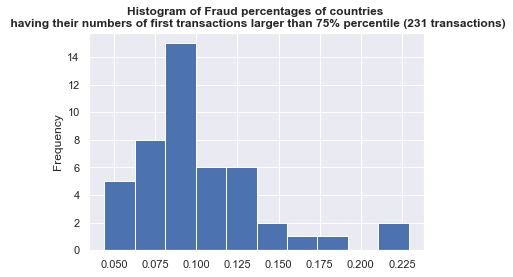

In [11]:
filtered_country_fraud_pct.hist()
plt.title('Histogram of Fraud percentages of countries \n having their numbers of first transactions larger than 75% percentile (231 transactions)',
         fontweight='bold')
plt.ylabel('Frequency')
plt.show()

#### Remaining features

There is no material difference in purchase value, sources, browsers, genders and ages between fraudulent and benign transactions.

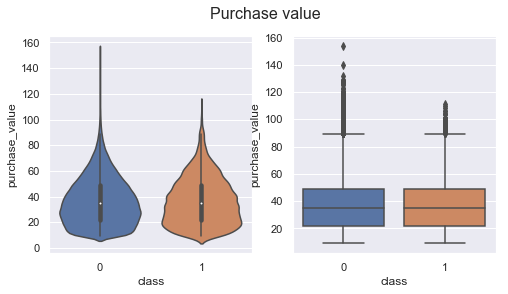

In [12]:
plt.subplots(1, 2, figsize=(8, 4))
plt.suptitle('Purchase value', fontsize=16)
plt.subplot(1, 2, 1)
sns.violinplot(x='class', y='purchase_value', data=data2[['class', 'purchase_value']])
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='purchase_value', data=data2[['class', 'purchase_value']])
plt.show()

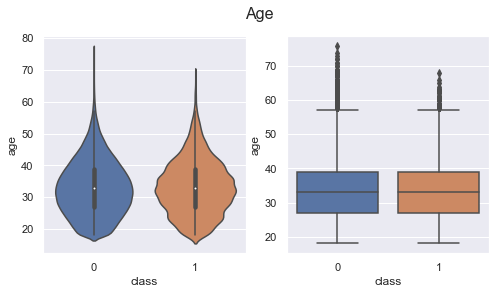

In [13]:
plt.subplots(1, 2, figsize=(8, 4))
plt.suptitle('Age', fontsize=16)
plt.subplot(1, 2, 1)
sns.violinplot(x='class', y='age', data=data2[['class', 'age']])
plt.subplot(1, 2, 2)
sns.boxplot(x='class', y='age', data=data2[['class', 'age']])
plt.show()

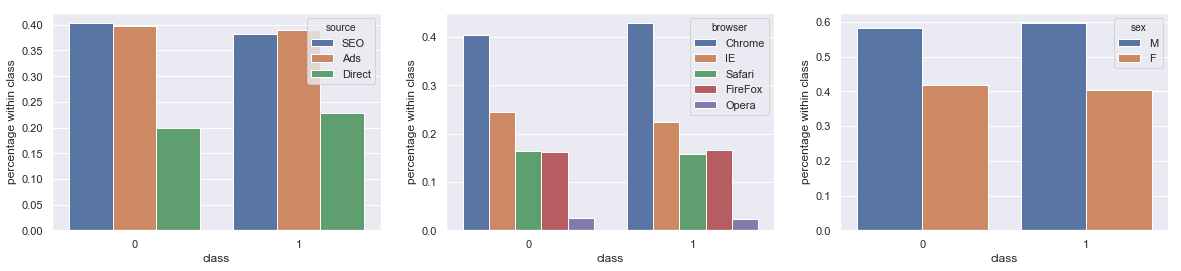

In [14]:
def plot_pct(data, x, y, hue, ax=None):
    data_pct = data[hue].groupby(data[x]).value_counts(normalize=True).rename(y).reset_index()
    sns.barplot(x=x, y=y, hue=hue, data=data_pct, ax=ax)

fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for i, hue in enumerate(['source', 'browser', 'sex']):
    plot_pct(data=data2, x='class', y='percentage within class', hue=hue, ax=axes[i])

# Preprocessing

We transform categorical features with one hot coding and normalize numerical features with min-max scaling for later modeling.

In [15]:
data3 = data2[[
 'purchase_value',
 'source',
 'browser',
 'sex',
 'age',
 'class',
 'country',
 'timedelta',
 'past_fraud_device']]

data3.replace(country_cumpct[country_cumpct > 0.9].index, 'Others', inplace=True)

data3.head()

purchase_value source browser sex  age  class        country  \
user_id                                                                 
22058                34    SEO  Chrome   M   39      0          Japan   
333320               16    Ads  Chrome   F   53      0  United States   
1359                 15    SEO   Opera   M   53      1  United States   
150084               44    SEO  Safari   M   41      0            NAN   
221365               39    Ads  Safari   M   45      0  United States   

         timedelta  past_fraud_device  
user_id                                
22058    52.160671                  0  
333320    0.207685                  0  
1359      0.000012                  1  
150084    5.695428                  0  
221365   50.479873                  0

In [16]:
obj_data = data3.select_dtypes(include=['object']).copy()
obj_encoded = pd.get_dummies(obj_data)
obj_encoded.head()

source_Ads  source_Direct  source_SEO  browser_Chrome  \
user_id                                                          
22058             0              0           1               1   
333320            1              0           0               1   
1359              0              0           1               0   
150084            0              0           1               0   
221365            1              0           0               0   

         browser_FireFox  browser_IE  browser_Opera  browser_Safari  sex_F  \
user_id                                                                      
22058                  0           0              0               0      0   
333320                 0           0              0               0      1   
1359                   0           0              1               0      0   
150084                 0           0              0               1      0   
221365                 0           0              0               1      0   

         sex_M          ...            country_Others  country_Poland  \
user_id                 ...                                             
22058        1          ...                         0               0   
333320       0          ...                         0               0   
1359         1          ...                         0               0   
150084       1          ...                         0               0   
221365       1          ...                         0               0   

         country_Russian Federation  country_South Africa  country_Spain  \
user_id                                                                    
22058                             0                     0              0   
333320                            0                     0              0   
1359                              0                     0              0   
150084                            0                     0              0   
221365                            0                     0              0   

         country_Sweden  country_Switzerland  \
user_id                                        
22058                 0                    0   
333320                0                    0   
1359                  0                    0   
150084                0                    0   
221365                0                    0   

         country_Taiwan; Republic of China (ROC)  country_United Kingdom  \
user_id                                                                    
22058                                          0                       0   
333320                                         0                       0   
1359                                           0                       0   
150084                                         0                       0   
221365                                         0                       0   

         country_United States  
user_id                         
22058                        0  
333320                       1  
1359                         1  
150084                       0  
221365                       1  

[5 rows x 33 columns]

In [17]:
num_data = data3.select_dtypes(exclude=['object']).drop(['class'], axis=1)

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
num_scaled = pd.DataFrame(min_max_scaler.fit_transform(num_data),
                          columns=num_data.columns, index=num_data.index)

num_scaled.head()

purchase_value       age  timedelta  past_fraud_device
user_id                                                        
22058          0.172414  0.362069   0.434673                0.0
333320         0.048276  0.603448   0.001731                0.0
1359           0.041379  0.603448   0.000000                1.0
150084         0.241379  0.396552   0.047462                0.0
221365         0.206897  0.465517   0.420667                0.0

In [18]:
from sklearn.model_selection import train_test_split

X = pd.concat([num_scaled, obj_encoded], axis=1)
y = data3['class']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
_, Xval, _, yval = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=RANDOM_STATE)

## Imbalanced classes

Our dataset has significantly imbalanced classes which is a not uncommon classification problem in fraud detection: 90% transactions are benign and only 10% transactions are fraudulent. In such case, a very naive model predicting any arbitrary transaction is always fraudulent can even achieve $accuracy = 90\%$.

Hence, oversampling and undersampling methods are employed to handle this imbalanced dataset and information retrieval performance metrics are useful.

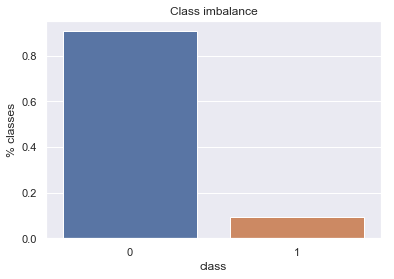

In [19]:
ax = sns.barplot(x='class', y='class', data=data, estimator=lambda x: 1.0 * len(x) / data.shape[0])
ax.set(ylabel='% classes')
plt.title('Class imbalance')
plt.show()

### Oversampling - SMOTE

In [20]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_STATE, n_jobs=-1)
X_smote, y_smote = smote.fit_sample(Xtrain, ytrain)
X_smote, y_smote = shuffle(X_smote, y_smote, random_state=RANDOM_STATE)

### Undersampling - RandomUnderSampler

In [21]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_sample(Xtrain, ytrain)
X_rus, y_rus = shuffle(X_rus, y_rus, random_state=RANDOM_STATE)

### Combined class methods - SMOTE + ENN

In [22]:
# start = time.time()
# from imblearn.combine import SMOTEENN
# sme = SMOTEENN(random_state=RANDOM_STATE, n_jobs=-1)
# X_snn, y_snn = sme.fit_sample(Xtrain, ytrain)
# X_snn, y_snn = shuffle(X_snn, y_snn, random_state=RANDOM_STATE)
# elapsed = time.time() - start
# print elapsed

In [23]:
# inputtypes = ['Imbalanced data', 'SMOTE', 'RandomUnderSampling', 'SMOTE+ENN']
# Xtypes = [Xtrain, X_smote, X_rus, X_snn]
# ytypes = [ytrain, y_smote, y_rus, y_snn]

inputtypes = ['Imbalanced data', 'SMOTE', 'RandomUnderSampling']
Xtypes = [Xtrain, X_smote, X_rus]
ytypes = [ytrain, y_smote, y_rus]


# inputtypes = ['SMOTE']
# Xtypes = [X_smote]
# ytypes = [y_smote]

# Model selection

Performance metrics are precision, recall, F1 score and Area under the Receiver Operating Characteristic Curve (ROC AUC) are used to evaluate models and their validations.

Model selecting process starts with simple models and moves to more complex models the bias-variance tradeoff observed from their learning curves allows. If a simplier model has low variance, a more complicated model is then validated on the training data until its variance is significant because predicting power of high-variance models is expected to be low for out-of-sample data.

##### Scoring metrics

In [24]:
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

precision_scorer = make_scorer(precision_score, greater_is_better=True)
recall_scorer = make_scorer(recall_score, greater_is_better=True)
f1_scorer = make_scorer(f1_score, greater_is_better=True)
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

from collections import OrderedDict

scorers = OrderedDict([('Precision', precision_scorer),
          ('Recall', recall_scorer),
          ('F1', f1_scorer),
          ('AUROC', roc_auc_scorer)])

## Logistic regression

Logistic regression has its learning curves with low variances and potential improvements in its bias. Models trained with imbalanced data yield highly poor performance with F1 score of apparently nothing and AUROC of 50% while the methods dealing with the imbalanced problem significantly improve the performance by similar amounts.

### Validation

In [25]:
from utilities import plot_validation_curve

from matplotlib.font_manager import FontProperties

def plot_validation(estimator, X, y,
                    scorers, param_name, param_range,
                    cv, n_jobs,
                    title, title_size=None, title_bold=True, figsize=None, xlog=False, verbose=False):
    if figsize is  None: figsize=(10, 6)
    plt.subplots(2, 2, figsize=figsize)

    fp = FontProperties(family="sans-serif", size=title_size, weight="bold")
    plt.suptitle(title).set_fontproperties(fp)
    
    for i, score_name in enumerate(scorers.keys()):
        scoring=scorers[score_name]

        plt.subplot(2, 2, i+1)

        plot_validation_curve(estimator=estimator, X=X, y=y,
                              scoring=scoring,
                              param_name=param_name, param_range=param_range,
                              title=score_name, cv=cv, n_jobs=-1, xlog=xlog, verbose=verbose)
        

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Imbalanced data


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    5.1s finished


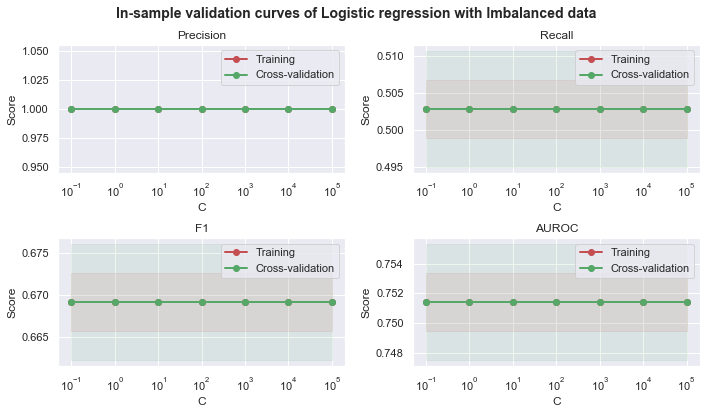

24.8640100956
SMOTE


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   27.6s finished
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   29.9s finished
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   31.3s finished
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   38.7s finished


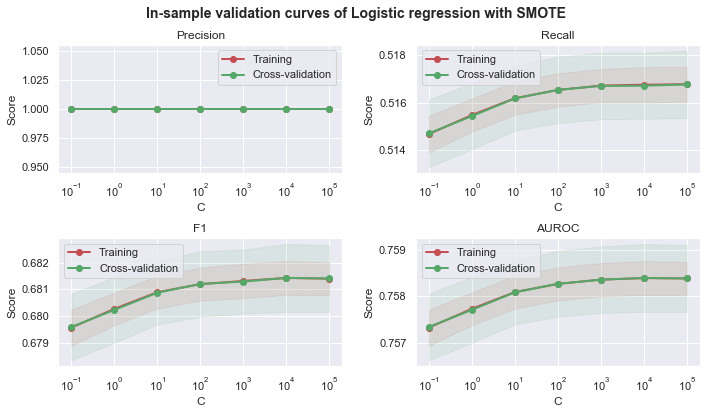

131.233335972
RandomUnderSampling


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.5s finished


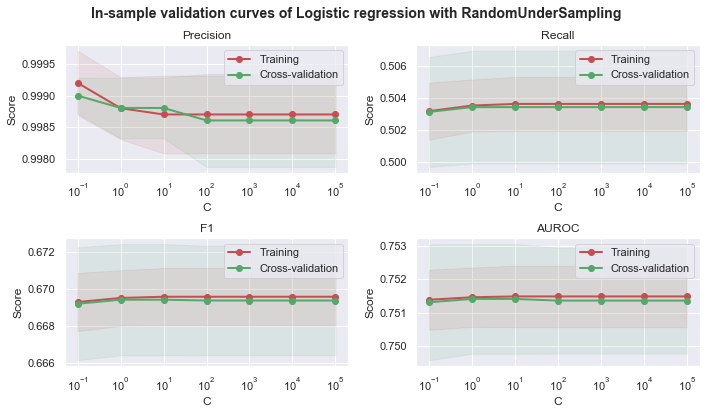

11.0959999561


In [26]:
from sklearn.linear_model import LogisticRegression

for inputType, Xtype, ytype in zip(inputtypes, Xtypes, ytypes):
    print inputType
    start = time.time()
    plot_validation(LogisticRegression(), Xtype, ytype,
                    scorers=scorers, param_name='C', param_range=np.logspace(-1, 5, 7),
                    cv=3, n_jobs=-1,
                    title='In-sample validation curves of Logistic regression with ' + inputType,
                    title_size=14, figsize=(10, 6), xlog=True, verbose=True)
    plt.show()
    
    elapsed = time.time() - start
    print elapsed

### In-sample training

In [33]:
from utilities import plot_learning_curve

def plot_learning(estimator, X, y, scorers,
                  cv, n_jobs,
                  title, title_size=None, title_bold=True, figsize=None, verbose=False):
    if figsize is  None: figsize=(10, 6)
    plt.subplots(2, 2, figsize=figsize)

    fp = FontProperties(family="sans-serif", size=title_size, weight="bold")
    plt.suptitle(title).set_fontproperties(fp)
    
    for i, score_name in enumerate(scorers.keys()):
        print score_name
        scoring=scorers[score_name]

        plt.subplot(2, 2, i+1)

        plot_learning_curve(estimator=estimator, scoring=scoring, title=score_name,
                        X=X, y=y, ylim=None, cv=cv,
                        n_jobs=n_jobs, train_sizes=np.linspace(.1, 1.0, 5), verbose=verbose)
        

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

[learning_curve] Training set sizes: [ 7051 22918 38784 54651 70518]
[learning_curve] Training set sizes: [ 7051 22918 38784 54651 70518]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.9s finished


[learning_curve] Training set sizes: [ 7051 22918 38784 54651 70518]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.1s finished


[learning_curve] Training set sizes: [ 7051 22918 38784 54651 70518]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.1s finished


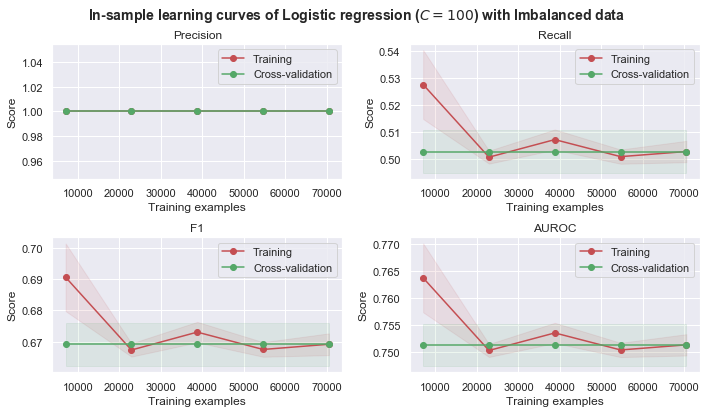

[learning_curve] Training set sizes: [ 12779  41532  70285  99038 127792]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   16.0s finished


[learning_curve] Training set sizes: [ 12779  41532  70285  99038 127792]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   18.1s finished


[learning_curve] Training set sizes: [ 12779  41532  70285  99038 127792]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   17.8s finished


[learning_curve] Training set sizes: [ 12779  41532  70285  99038 127792]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   17.4s finished


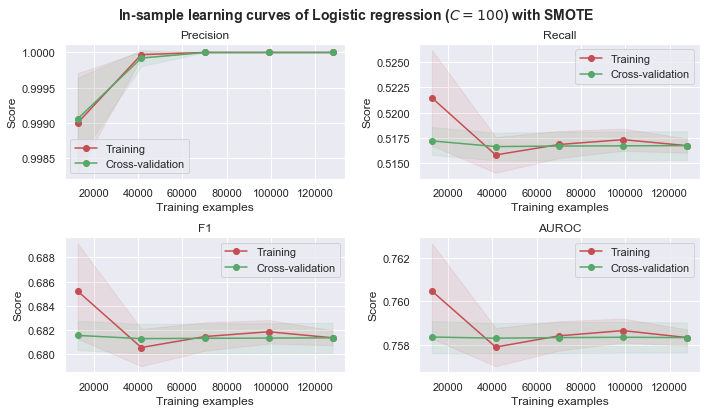

[learning_curve] Training set sizes: [ 1324  4304  7284 10264 13244]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.8s finished


[learning_curve] Training set sizes: [ 1324  4304  7284 10264 13244]
[learning_curve] Training set sizes: [ 1324  4304  7284 10264 13244]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.8s finished


[learning_curve] Training set sizes: [ 1324  4304  7284 10264 13244]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished


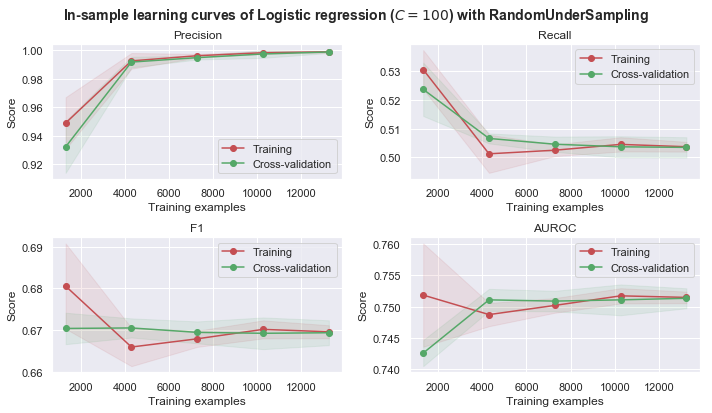

89.8958919048


In [34]:
start = time.time()
for inputType, Xtype, ytype in zip(inputtypes, Xtypes, ytypes):
    plot_learning(LogisticRegression(C=100), Xtype, ytype, scorers,
             cv=3, n_jobs=-1,
             title='In-sample learning curves of Logistic regression ($C=100$) with ' + inputType,
             title_size=14, figsize=(10, 6), verbose=True)

    plt.show()
    
elapsed = time.time() - start
print elapsed

## Decision tree

After logistic regression, decision tree classification is evaluated for in-sample data thanks to the previous low variances.

Imbalanced and RandomUnderSampling data suffer high variances with decision tree models while the algorithms impressively improve performances of SMOTE and SMOTE+ENN data. Hence, the two SMOTE datasets are trained using Random Forest.

### Validation

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.3s finished


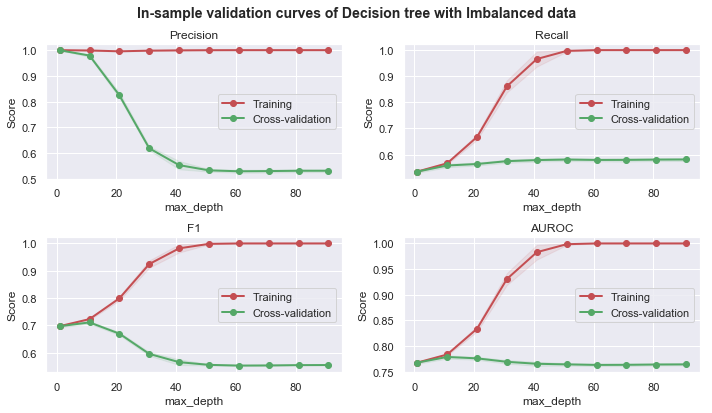

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   37.9s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   40.3s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   46.1s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   36.7s finished


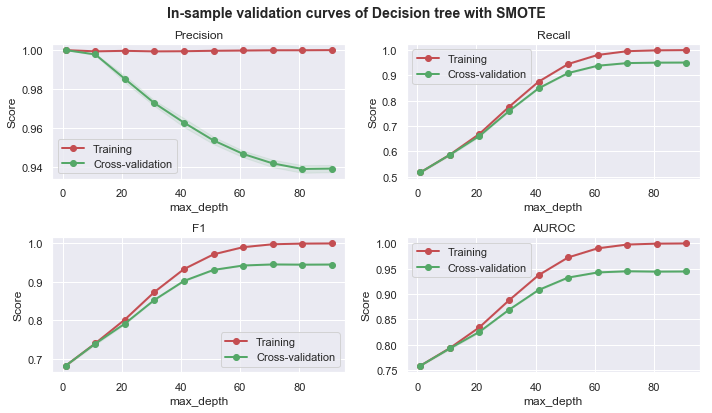

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished


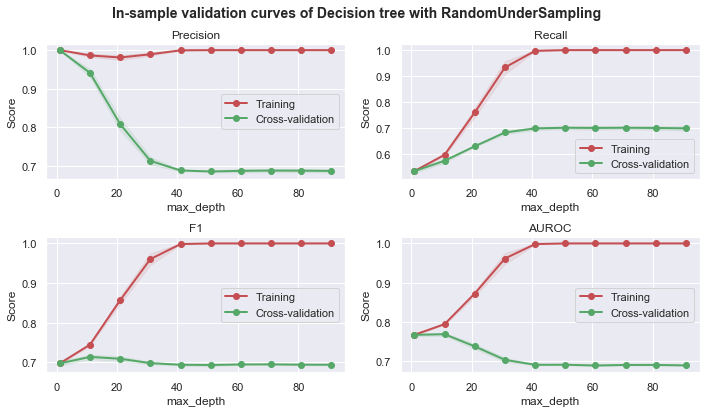

220.20706892


In [37]:
from sklearn.tree import DecisionTreeClassifier

start = time.time()
for inputType, Xtype, ytype in zip(inputtypes, Xtypes, ytypes):
    plot_validation(DecisionTreeClassifier(), Xtype, ytype,
                    scorers=scorers, param_name='max_depth', param_range=np.arange(1, 101, 10),
                    cv=3, n_jobs=-1,
                    title='In-sample validation curves of Decision tree with ' + inputType,
                    title_size=14, figsize=(10, 6), xlog=False, verbose=True)
    plt.show()
elapsed = time.time() - start
print elapsed

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished


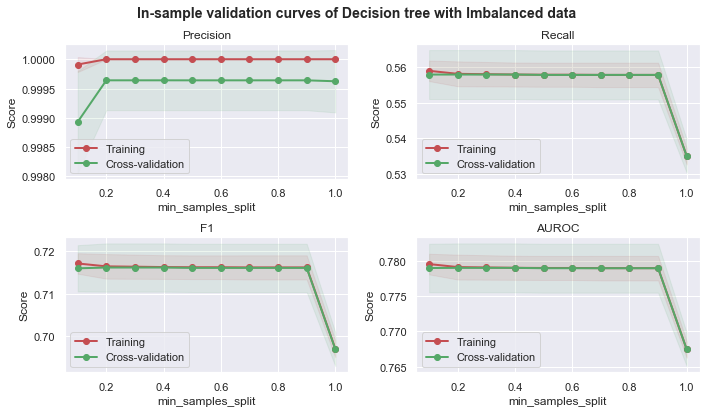

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.9s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.3s finished


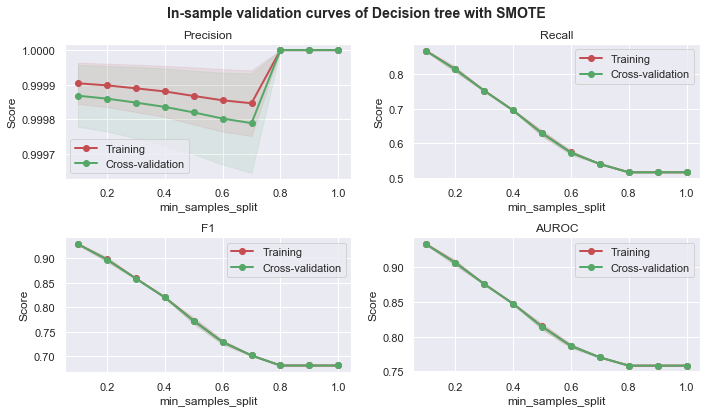

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


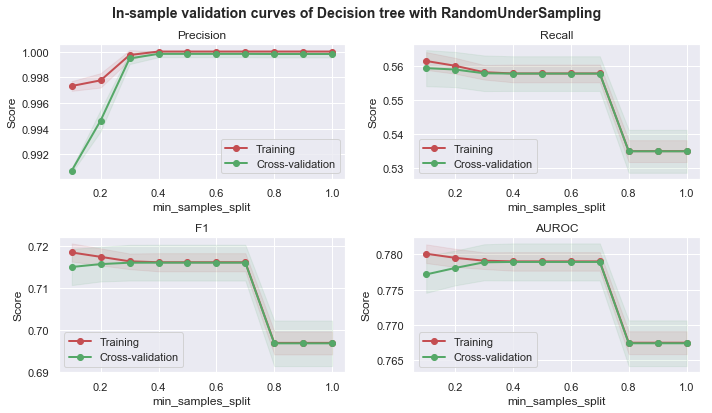

116.814551115


In [39]:
start = time.time()
for inputType, Xtype, ytype in zip(inputtypes, Xtypes, ytypes):
    plot_validation(DecisionTreeClassifier(random_state=RANDOM_STATE), Xtype, ytype,
                    scorers=scorers, param_name='min_samples_split', param_range=np.linspace(0.1, 1.0, 10, endpoint=True),
                    cv=3, n_jobs=-1,
                    title='In-sample validation curves of Decision tree with ' + inputType,
                    title_size=14, figsize=(10, 6), xlog=False, verbose=True)
    plt.show()
elapsed = time.time() - start
print elapsed

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


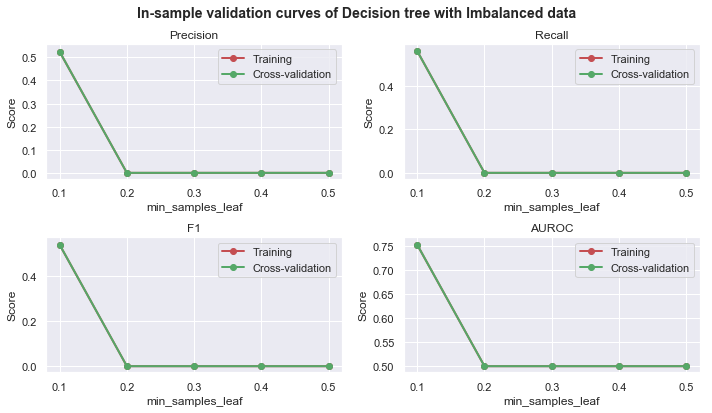

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.5s finished


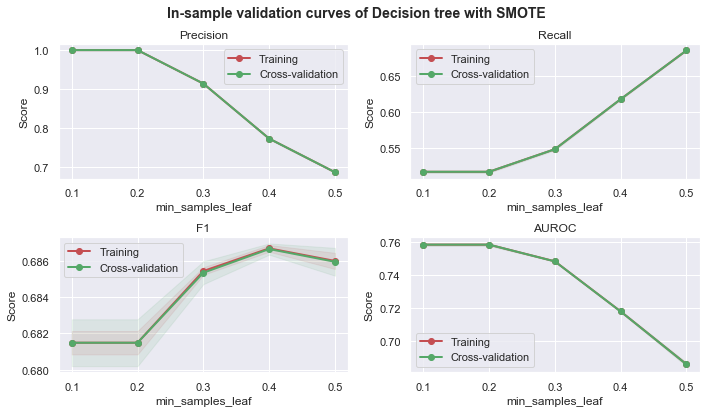

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished


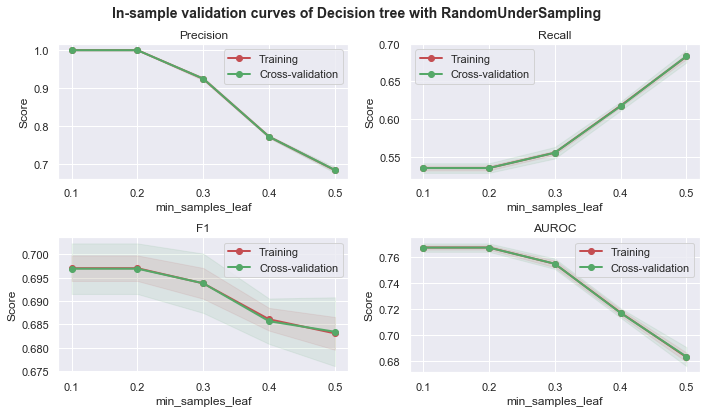

25.0297391415


In [40]:
start = time.time()

for inputType, Xtype, ytype in zip(inputtypes, Xtypes, ytypes):
    plot_validation(DecisionTreeClassifier(random_state=RANDOM_STATE), Xtype, ytype,
                    scorers=scorers, param_name='min_samples_leaf', param_range=np.linspace(0.1, 0.5, 5, endpoint=True),
                    cv=3, n_jobs=-1,
                    title='In-sample validation curves of Decision tree with ' + inputType,
                    title_size=14, figsize=(10, 6), xlog=False, verbose=True)
    
    
    plt.show()
    
elapsed = time.time() - start
print elapsed

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished


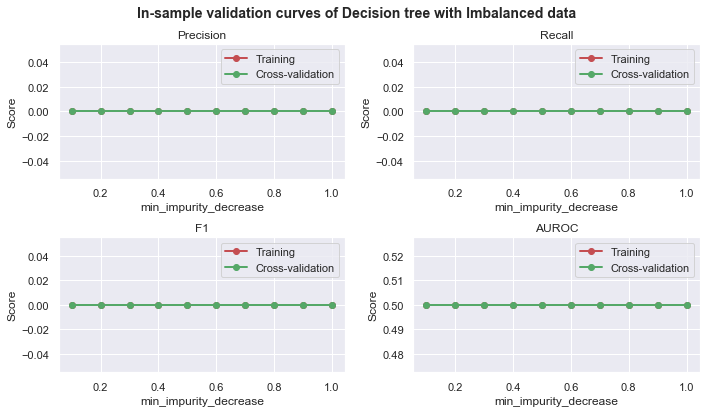

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.3s finished


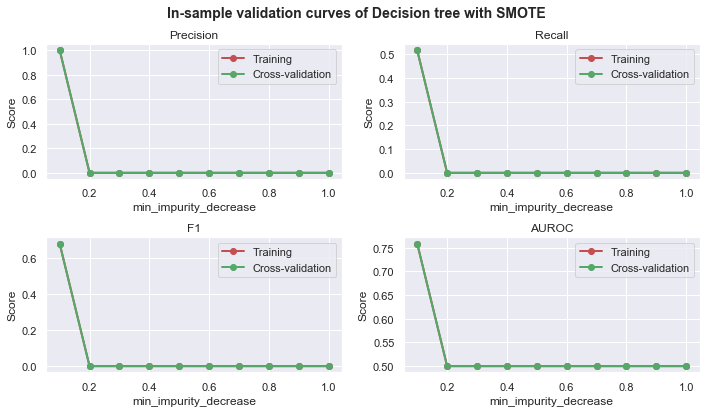

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


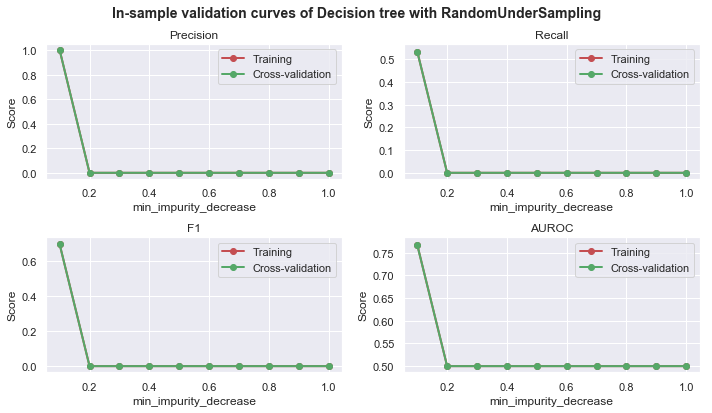

37.818775177


In [41]:
start = time.time()

for inputType, Xtype, ytype in zip(inputtypes, Xtypes, ytypes):
    plot_validation(DecisionTreeClassifier(random_state=RANDOM_STATE), Xtype, ytype,
                    scorers=scorers, param_name='min_impurity_decrease', param_range=np.linspace(0.1, 1.0, 10, endpoint=True),
                    cv=3, n_jobs=-1,
                    title='In-sample validation curves of Decision tree with ' + inputType,
                    title_size=14, figsize=(10, 6), xlog=False, verbose=True)
    
    
    plt.show()
    
elapsed = time.time() - start
print elapsed

### In-sample training

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

[learning_curve] Training set sizes: [ 7051 22918 38784 54651 70518]
[learning_curve] Training set sizes: [ 7051 22918 38784 54651 70518]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


[learning_curve] Training set sizes: [ 7051 22918 38784 54651 70518]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.2s finished


[learning_curve] Training set sizes: [ 7051 22918 38784 54651 70518]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished


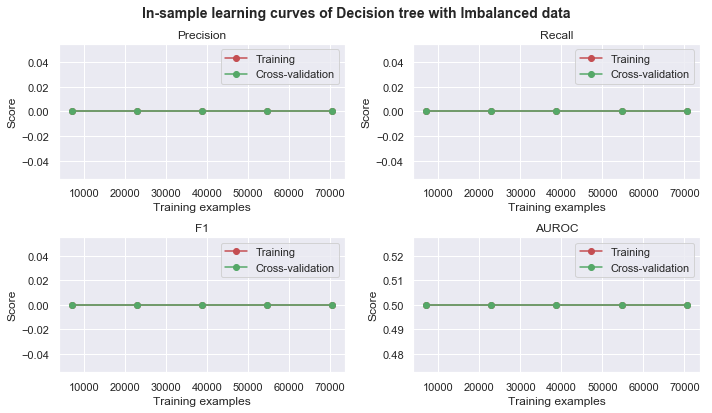

[learning_curve] Training set sizes: [ 12779  41532  70285  99038 127792]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.7s finished


[learning_curve] Training set sizes: [ 12779  41532  70285  99038 127792]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.2s finished


[learning_curve] Training set sizes: [ 12779  41532  70285  99038 127792]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.4s finished


[learning_curve] Training set sizes: [ 12779  41532  70285  99038 127792]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.0s finished


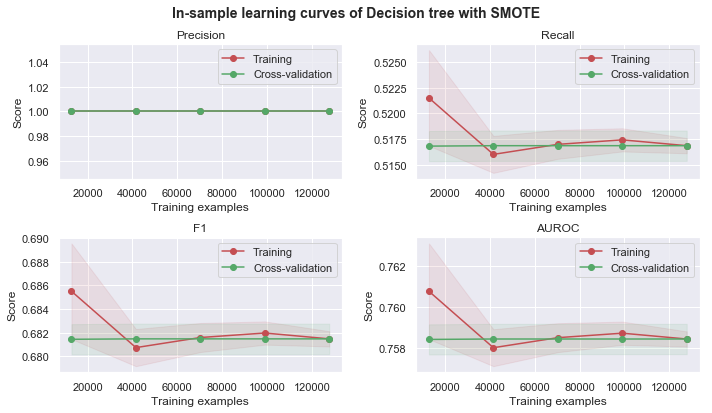

[learning_curve] Training set sizes: [ 1324  4304  7284 10264 13244]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished


[learning_curve] Training set sizes: [ 1324  4304  7284 10264 13244]
[learning_curve] Training set sizes: [ 1324  4304  7284 10264 13244]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.5s finished


[learning_curve] Training set sizes: [ 1324  4304  7284 10264 13244]


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished


24.7348480225


In [46]:
start = time.time()
for inputType, Xtype, ytype in zip(inputtypes, Xtypes, ytypes):
    plot_learning(DecisionTreeClassifier(max_depth=60,
                                         min_samples_split=2,
                                         min_samples_leaf=0.2,
                                         min_impurity_decrease=0.0,
                                         random_state=RANDOM_STATE), Xtype, ytype, scorers,
             cv=3, n_jobs=-1,
             title='In-sample learning curves of Decision tree with ' + inputType,
             title_size=14, figsize=(10, 6), verbose=True)

    plt.show()
    
elapsed = time.time() - start
print elapsed

### Final model

In [62]:
from sklearn.metrics import precision_recall_curve

def plotPRC(clf, X, y, color, label=str()):
    yscore = clf.predict_proba(X)[:, 1]
#     average_precision = average_precision_score(y, yscore)
    precision, recall, _ = precision_recall_curve(y, yscore)
    
    plt.step(recall, precision, color=color, alpha=0.2,
         where='post', label=label+' PRC')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color=color)
    
    yhat = clf.predict(X)
    precision_p = precision_score(y, yhat)
    recall_p = recall_score(y, yhat)
    f1_p = f1_score(y, yhat)
    auroc_p = roc_auc_score(y, yscore)
    
    plt.scatter(recall_p, precision_p, color=color, linewidth=5, label=label + ' threshold=50%. \n' \
                                                    + 'Precision: {:0.2f}%'.format(precision_p*100) + '\n' \
                                                    + 'Recall: {:0.2f}%'.format(recall_p*100) + '\n' \
                                                    + 'F1: {:0.2f}%'.format(f1_p*100) + '\n' \
#                                                     + 'Average precision: {:0.2f}%'.format(average_precision*100) + '\n' \
                                                    + 'AUROC: {:0.2f}%'.format(auroc_p*100))
    
def plotPerformance(clf, model_name, Xtrain, ytrain, Xtest, ytest, figsize=None, fontsize=None):
    if figsize is not None: plt.figure(figsize=figsize)
        
    plt.xlabel('Recall', fontsize=fontsize)
    plt.ylabel('Precision', fontsize=fontsize)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Performance of ' + model_name, fontsize=fontsize, fontweight='bold')

    plotPRC(clf, Xtrain, ytrain, color='b', label='In-sample')
    plotPRC(clf, Xtest, ytest, color='r', label='Out-of-sample')
    plt.legend()
    plt.show()

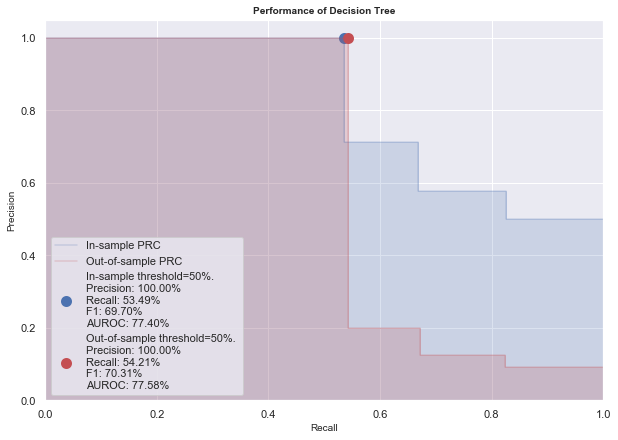

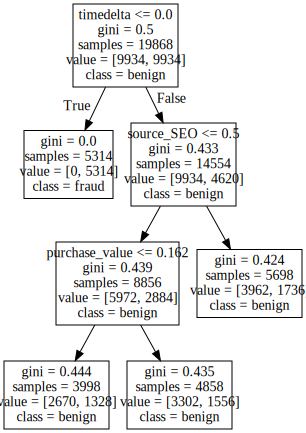

In [81]:
X_final = X_rus
y_final = y_rus

clf = DecisionTreeClassifier(max_depth=60, min_samples_leaf=0.2, random_state=RANDOM_STATE)
clf.fit(X_final, y_final)
from graphviz import Source
from sklearn import tree
plotPerformance(clf, 'Decision Tree', X_final, y_final, Xtest, ytest, figsize=(10, 7), fontsize=None)
Source(tree.export_graphviz(clf, out_file=None, feature_names=Xtrain.columns, class_names=['benign', 'fraud']))